In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import catboost as cb
from sklearn.utils import resample

In [3]:
california = fetch_california_housing()
X = california.data
y = california.target

In [4]:
## делим и нормализуем
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
catboost_model = cb.CatBoostRegressor(iterations=500, learning_rate=0.1, depth=10, random_state=42, verbose=0)

xgb_model.fit(X_train_scaled, y_train)
catboost_model.fit(X_train_scaled, y_train)

xgb_pred = xgb_model.predict(X_test_scaled)
catboost_pred = catboost_model.predict(X_test_scaled)

xgb_mse_no_mc = mean_squared_error(y_test, xgb_pred)
catboost_mse_no_mc = mean_squared_error(y_test, catboost_pred)

xgb_r2_no_mc = r2_score(y_test, xgb_pred)
catboost_r2_no_mc = r2_score(y_test, catboost_pred)

In [6]:
print(f"XGBoost without Monte Carlo - MSE: {xgb_mse_no_mc}, R²: {xgb_r2_no_mc}")
print(f"CatBoost without Monte Carlo - MSE: {catboost_mse_no_mc}, R²: {catboost_r2_no_mc}")

XGBoost without Monte Carlo - MSE: 0.2225899267544737, R²: 0.8301370561019205
CatBoost without Monte Carlo - MSE: 0.1959817773956126, R²: 0.8504422812649683


In [7]:
## Функция для обучения, оценки качества, подсчета статистик и доверительных интервалов
def train_and_evaluate(model, X_train, y_train, X_test, y_test, n_simulations=30):
    predictions = []
    for _ in range(n_simulations):
        # Бутстрэп
        X_resampled, y_resampled = resample(X_train, y_train, random_state=None)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

    # Cписок предсказаний в массив
    predictions = np.array(predictions)

    # Считаем статистики
    mean_predictions = predictions.mean(axis=0)
    std_predictions = predictions.std(axis=0)

    # Доверительные интервалы
    lower_bound = mean_predictions - 1.96 * std_predictions
    upper_bound = mean_predictions + 1.96 * std_predictions

    # Метрики
    mse = mean_squared_error(y_test, mean_predictions)
    r2 = r2_score(y_test, mean_predictions)

    return mean_predictions, lower_bound, upper_bound, mse, r2, predictions

In [8]:
## Обучим XGBoost и CatBoost с использованием методов Монте-Карло
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_mean, xgb_lower, xgb_upper, xgb_mse, xgb_r2, xgb_preds = train_and_evaluate(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [9]:
catboost_model = cb.CatBoostRegressor(iterations=500, learning_rate=0.1, depth=10, random_state=42, verbose=0)
catboost_mean, catboost_lower, catboost_upper, catboost_mse, catboost_r2, catboost_preds = train_and_evaluate(catboost_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [10]:
print(f"XGBoost - MSE: {xgb_mse}, R²: {xgb_r2}")
print(f"CatBoost - MSE: {catboost_mse}, R²: {catboost_r2}")

XGBoost - MSE: 0.19874275811318998, R²: 0.8483353201837922
CatBoost - MSE: 0.19832699493695666, R²: 0.8486525976011001


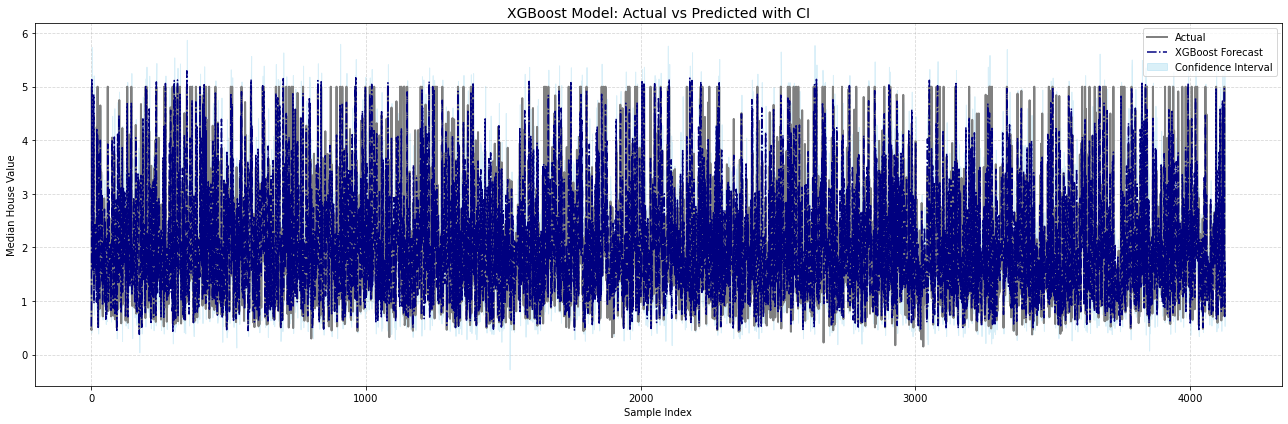

In [15]:
## XGBoost
plt.figure(figsize=(18, 6))
plt.plot(y_test, color='gray', label='Actual', linewidth=2)
plt.plot(xgb_mean, color='navy', linestyle='-.', label='XGBoost Forecast')
plt.fill_between(range(len(xgb_mean)), xgb_lower, xgb_upper, color='skyblue', alpha=0.3, label='Confidence Interval')

plt.title('XGBoost Model: Actual vs Predicted with CI', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('Median House Value')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

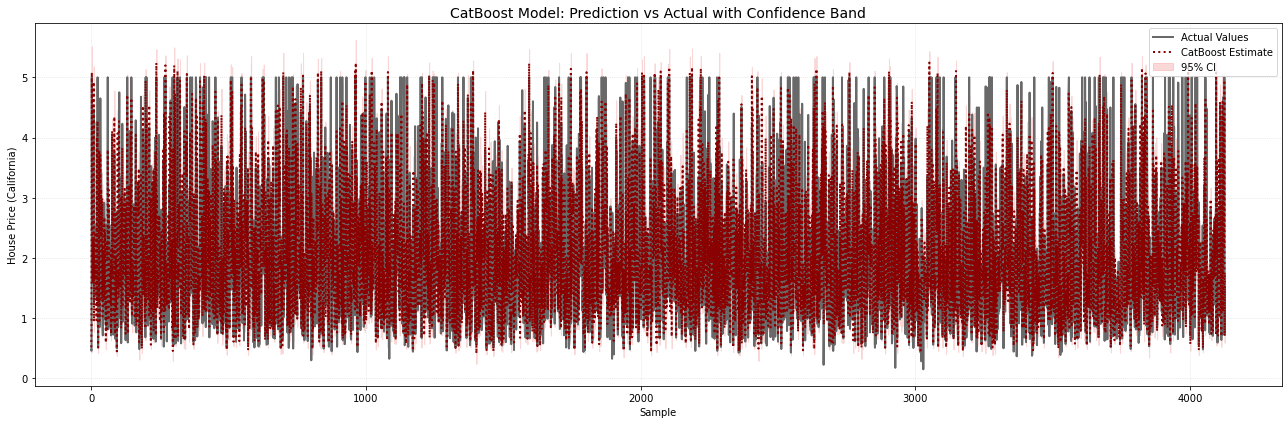

In [16]:
## CatBoost
plt.figure(figsize=(18, 6))
plt.plot(y_test, color='dimgray', linewidth=2, label='Actual Values')
plt.plot(catboost_mean, color='darkred', linestyle=':', linewidth=2, label='CatBoost Estimate')
plt.fill_between(range(len(catboost_mean)), catboost_lower, catboost_upper, color='lightcoral', alpha=0.3, label='95% CI')

plt.title('CatBoost Model: Prediction vs Actual with Confidence Band', fontsize=14)
plt.xlabel('Sample')
plt.ylabel('House Price (California)')
plt.legend(loc='best')
plt.grid(alpha=0.4, linestyle=':')

plt.tight_layout()
plt.show()


## Вывод

В обоих случаях можно заметить, что модель CatBoost демонстрирует более низкое значение MSE и более высокое значение R² по сравнению с XGBoost, что обычно свидетельствует о её большей стабильности и точности.

Интересно, что после применения методов Монте-Карло у XGBoost показатели улучшились: MSE немного снизилось, а R² — увеличилось. В то же время у CatBoost наблюдается небольшое ухудшение метрик, что, возможно, связано с особенностями бутстрэп-сэмплирования.








